### Import libraries

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inspect
import pickle
import os
import glob

In [19]:
raw_df = pd.read_csv(f'graphs/gowalla/austin/raw.csv')
raw_df

,Unnamed: 0,trial,early_stopping_level,scheduler_type,eps_cmp,base_eps,geo_eps,method,return_size,raw_acc,top_5_acc,precision,recall
0,0,0,1,constant,0.096171,0.01,11.829051,DP-TT-CMP,1,False,False,0.000000,0.000000
1,1,0,1,constant,0.096171,0.01,2.010239,LAPLACE,1,False,False,0.000000,0.000000
2,2,0,1,constant,0.565906,0.01,11.829051,LAPLACE-GEO,1,False,False,0.000000,0.000000
3,3,0,1,constant,0.096171,0.01,NaN,L-SRR,1,False,False,0.000000,0.000000
4,4,0,1,constant,1.010489,0.10,80.806051,DP-TT-CMP,1,False,False,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95227,95227,499,9,constant,211.680000,12.00,NaN,L-SRR,176,False,False,0.000000,0.000000
95228,95228,499,9,constant,299.880000,17.00,80135.243414,DP-TT-CMP,176,True,True,0.045455,0.275862
95229,95229,499,9,constant,299.880000,17.00,6268.349358,LAPLACE,176,True,True,0.034091,0.206897
95230,95230,499,9,constant,3833.697745,17.00,80135.243414,LAPLACE-GEO,176,True,True,0.034091,0.206897


### Accuracy, precision, recall

In [24]:
def construct_graphs(output_dir):
    print(output_dir)
    raw_df = pd.read_csv(f'{output_dir}/raw.csv')

    with open(f'{output_dir}/metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)

    print("Number of relevant nodes in precision:", sum(metadata['number_of_nn_within_radius']) / len(metadata['number_of_nn_within_radius']))

    # rename columns
    raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE', 'L-SRR'])]
    raw_df['method'] = raw_df['method'].replace({'DP-TT-CMP': 'DP-TT', 'LAPLACE': 'Laplace'})
    raw_df['Mechanism'] = raw_df['method']

    # remove jitter from graph
    jitter_threshold = raw_df[raw_df['early_stopping_level'] == 1]['eps_cmp'].value_counts().tolist()[11]
    frequent_values_index = raw_df['eps_cmp'].value_counts()[raw_df['eps_cmp'].value_counts() >= jitter_threshold].index
    raw_df = raw_df[raw_df['eps_cmp'].isin(frequent_values_index)]

    print("Jitter threshold:", jitter_threshold)

    # change early_stopping_level to return_size
    for early_stopping_level in [1, 3, 5, 9]:
        raw_df.loc[raw_df['early_stopping_level'] == early_stopping_level, 'return_size'] = round(raw_df[raw_df['early_stopping_level'] == early_stopping_level]['return_size'].mean(), 2)
    raw_df['Return Set Size'] = raw_df['return_size']
    raw_df['early_stopping_level'] -= 1


    # graphs for these four
    metric_name = {
        'raw_acc': 'Raw Accuracy',
        'top_5_acc': 'Top 5 Accuracy',
        'precision': 'Precision',
        'recall': 'Recall',
    }

    for early_stopping_level in ['all', 0, 2, 4, 8]:
        if early_stopping_level == 'all':
            tmp_df = raw_df
        else:
            tmp_df = raw_df[raw_df['early_stopping_level'] == early_stopping_level]

        for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

            # plot for both DP-TT and LDP
            if early_stopping_level == 'all':
                plot = sns.lineplot(
                    data=tmp_df, x='eps_cmp', y=f'{metric}', 
                    hue='Return Set Size', style='Mechanism', markers=True,
                    palette='deep', alpha=0.75,
                )
            else:
                plot = sns.lineplot(
                    data=tmp_df, x='eps_cmp', y=f'{metric}', 
                    style='Mechanism', markers=True,
                    alpha=0.75,
                )

            # graph params
            plot.set(
        #         xlim=(0, 10),
                ylim=(-0.1, 1.1),
                xlabel='Total Epsilon',
                ylabel=metric_name[metric]
            )

            # move legend
            sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

            # save plot
            plot.get_figure().savefig(f'{output_dir}/{early_stopping_level}/{metric}.png', bbox_inches='tight', dpi=400)
            plt.close()
            plot.get_figure().clf()


    # precision-recall curves
    files = glob.glob(f'{output_dir}/precision_recall/*')
    for f in files:
        os.remove(f)

    for eps in raw_df['base_eps'].unique():
        tmp_df = raw_df[raw_df['base_eps'] == eps].groupby(['Mechanism', 'early_stopping_level'])
        mean_df = tmp_df[['precision', 'recall']].mean()

        # plot for both DP-TT and LDP
        plot = sns.lineplot(
            data=mean_df, x='recall', y='precision', 
            style='Mechanism', markers=True, alpha=0.75,
            # palette='deep',
        )

        # graph params
        plot.set(
            ylim=(-0.1, 1.1),
            xlim=(-0.1, 1.1),
            ylabel='Precision',
            xlabel='Recall',
            # title=f'Precision vs. recall for epsilon = {round(eps, 2)}'
        )

        # move legend
        sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

        # save file
        plot.get_figure().savefig(f'{output_dir}/precision_recall/eps_{round(tmp_df["eps_cmp"].unique().median(), 2)}_std_{round(tmp_df["eps_cmp"].unique().std(), 2)}.png', bbox_inches='tight', dpi=400)
        plt.close()
        plot.get_figure().clf()

    

In [25]:
all_output_dirs = [
    'graphs/densities/1000',
    'graphs/densities/10000',
    'graphs/densities/100000',
    'graphs/densities/1000000',
    'graphs/gowalla/austin/',
    'graphs/gowalla/sf/',
    'graphs/1d/1000/',
    'graphs/1d/10000/',
    'graphs/1d/100000/',
]

In [26]:
for output_dir in all_output_dirs:
    construct_graphs(output_dir)

graphs/densities/1000
Number of relevant nodes in precision: 28.71
Jitter threshold: 1404
graphs/densities/10000
Number of relevant nodes in precision: 30.578
Jitter threshold: 1065
graphs/densities/100000
Number of relevant nodes in precision: 31.294
Jitter threshold: 777
graphs/densities/1000000
Number of relevant nodes in precision: 31.662
Jitter threshold: 1263
graphs/gowalla/austin/
Number of relevant nodes in precision: 35.655310621242485
Jitter threshold: 762
graphs/gowalla/sf/
Number of relevant nodes in precision: 24.058
Jitter threshold: 1332
graphs/1d/1000/
Number of relevant nodes in precision: 35.288
Jitter threshold: 834
graphs/1d/10000/
Number of relevant nodes in precision: 35.352
Jitter threshold: 596
graphs/1d/100000/
Number of relevant nodes in precision: 24.874
Jitter threshold: 520


### DIS Exploration

In [2]:
db_size = 10 ** 6
domain = 10 ** 7

output_dir = f'graphs/densities/size_{db_size}_domain_{domain}/'
raw_df = pd.read_csv(f'{output_dir}raw.csv')

with open(f'{output_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [3]:
raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE-GEO'])]
# raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE', 'L-SRR'])]

In [4]:
for early_stopping_level in [1, 3, 5, 9]:
    raw_df.loc[raw_df['early_stopping_level'] == early_stopping_level, 'return_size'] = round(raw_df[raw_df['early_stopping_level'] == early_stopping_level]['return_size'].mean(), 2)

In [5]:
raw_df['geo_eps'] = (raw_df['geo_eps'] / 500).round().astype(int) * 500

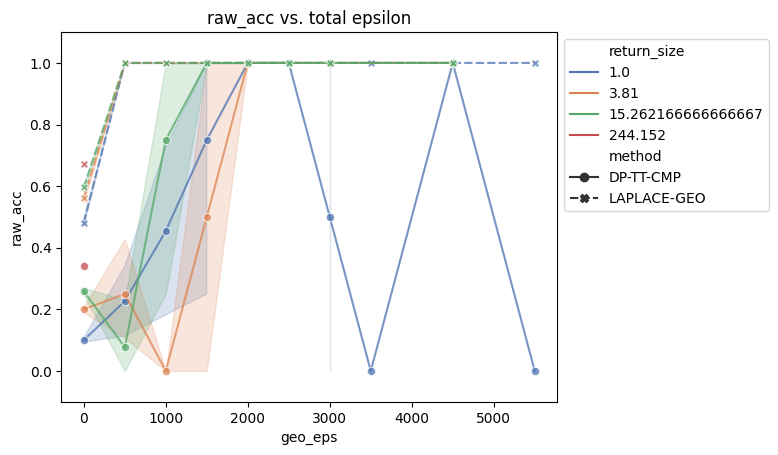

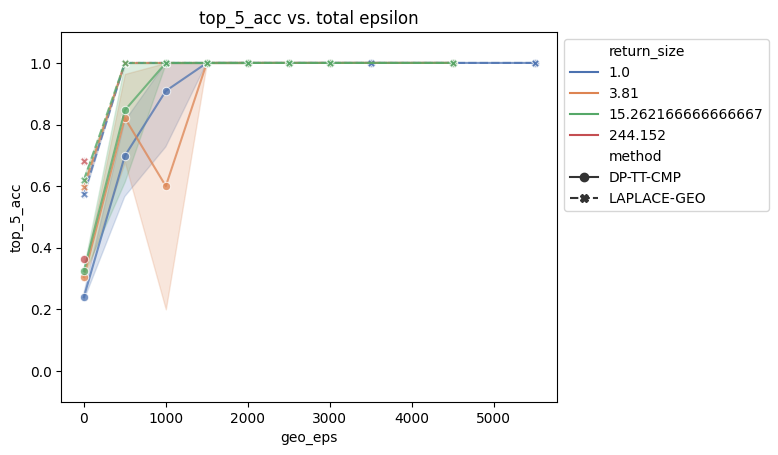

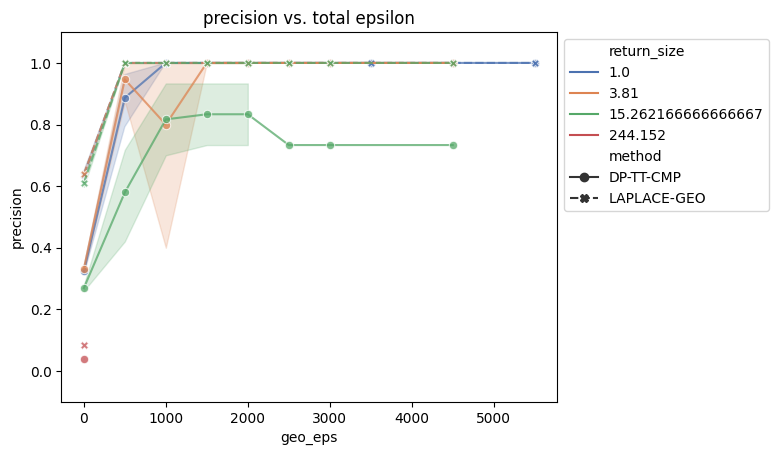

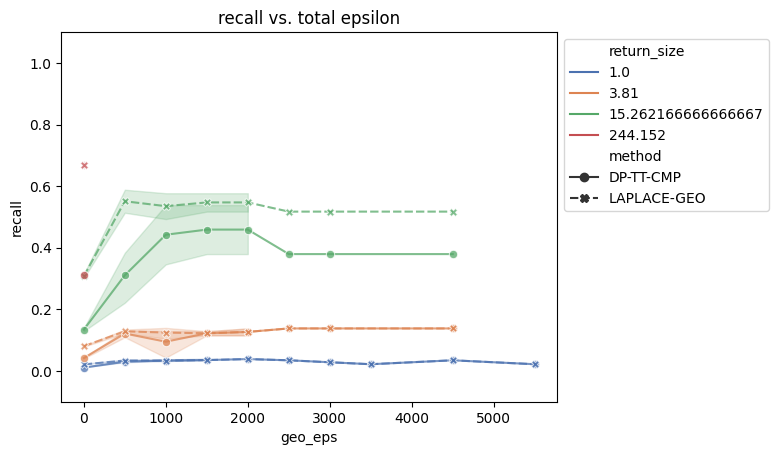

In [6]:
for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

    # plot for both DP-TT and LDP
    plot = sns.lineplot(
        data=raw_df, x='geo_eps', y=f'{metric}', 
        hue='return_size', style='method', markers=True,
        palette='deep', alpha=0.75,
    )

    # graph params
    plot.set(
        ylim=(-0.1, 1.1),
#         xlim=(0, 10),
        title=f'{metric} vs. total epsilon'
    )

    # move legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    
    plt.show()

    # save plot
    # plot.get_figure().savefig(f'{output_dir}/dis/{metric}_dis.png', bbox_inches='tight', dpi=400)
    plot.get_figure().clf()

### Scheduler Graphs

In [3]:
db_size = 10 ** 5
domain = 10 ** 7

input_dir = f'graphs/schedulers/scheduler_1.6/size_{db_size}_domain_{domain}/'
output_dir = f'graphs/schedulers/inverse/'
raw_df = pd.read_csv(f'{input_dir}raw.csv')

with open(f'{input_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [4]:
metadata

{'dimension': 2,
 'server_size': 100000,
 'server_domain': 3162.2776601683795,
 'client_batch_size': 500,
 'client_sensitivity': 3162.2776601683795,
 'true_radius': 31,
 'early_stopping_levels': [5],
 'number_of_nn_within_radius': [33,
  29,
  33,
  27,
  36,
  38,
  34,
  35,
  38,
  39,
  25,
  29,
  35,
  28,
  35,
  37,
  37,
  42,
  34,
  23,
  40,
  35,
  30,
  27,
  32,
  31,
  41,
  31,
  28,
  30,
  28,
  28,
  27,
  36,
  27,
  28,
  18,
  34,
  37,
  35,
  31,
  37,
  27,
  18,
  29,
  24,
  34,
  31,
  27,
  41,
  20,
  29,
  48,
  26,
  28,
  26,
  37,
  42,
  28,
  35,
  34,
  31,
  25,
  23,
  27,
  32,
  21,
  26,
  31,
  29,
  36,
  37,
  29,
  31,
  25,
  32,
  28,
  29,
  30,
  28,
  31,
  32,
  38,
  31,
  29,
  26,
  25,
  35,
  28,
  35,
  26,
  34,
  32,
  43,
  28,
  24,
  29,
  28,
  34,
  32,
  35,
  32,
  34,
  51,
  37,
  37,
  32,
  31,
  30,
  35,
  26,
  29,
  30,
  32,
  39,
  31,
  39,
  40,
  29,
  27,
  29,
  35,
  35,
  20,
  31,
  47,
  29,
  34,
  

In [102]:
raw_df = raw_df[raw_df['scheduler_type'].isin(['constant', 'inverse_sqrt', 'inverse_linear', 'inverse_quadratic'])]

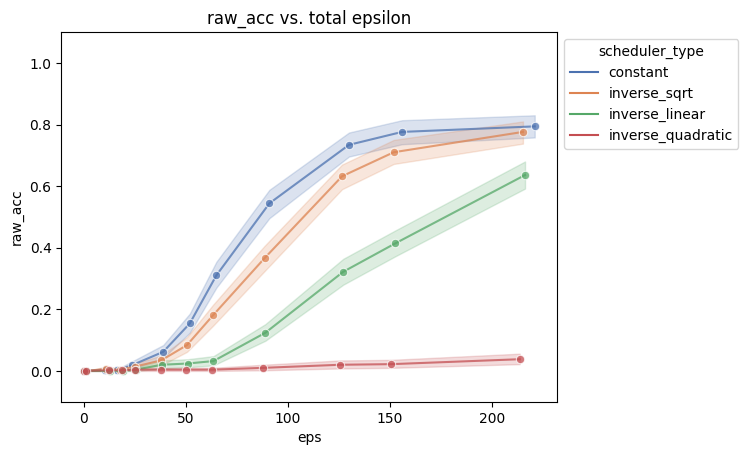

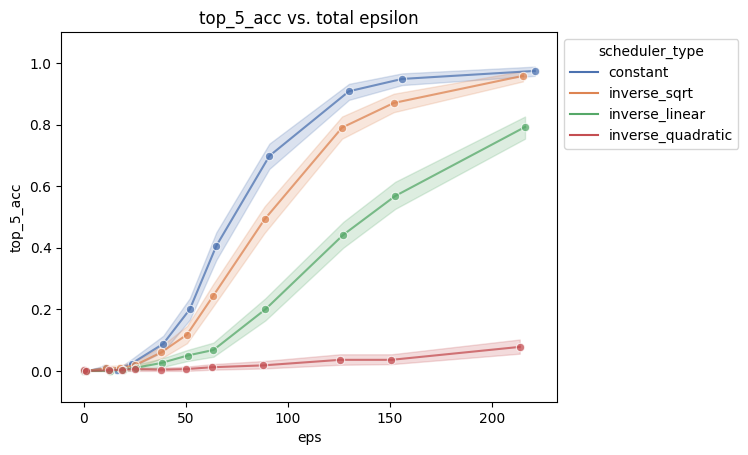

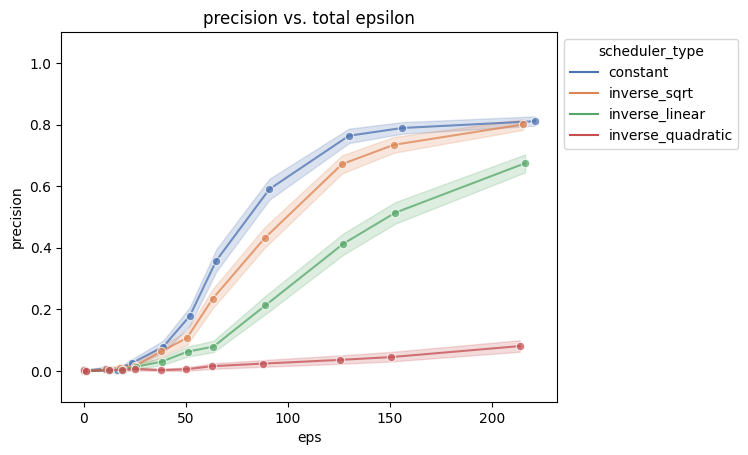

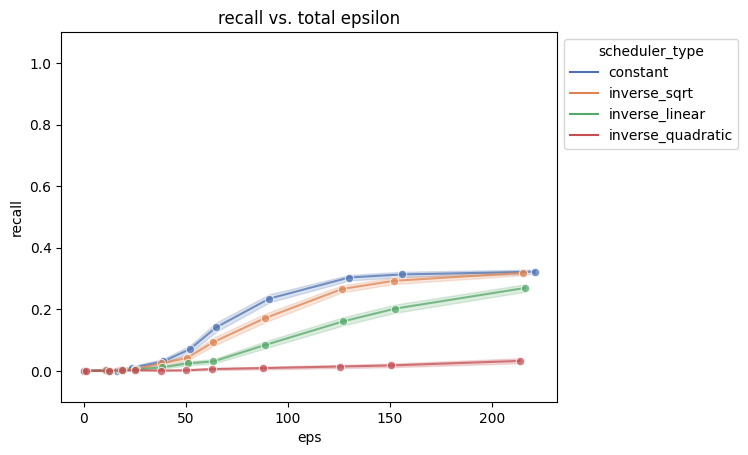

In [103]:
for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

    # plot for both DP-TT and LDP
    plot = sns.lineplot(
        data=raw_df, x='eps_cmp', y=f'{metric}', 
        hue='scheduler_type',
        palette='deep', alpha=0.75, marker='o',
    )

    # graph params
    plot.set(
        ylim=(-0.1, 1.1),
        title=f'{metric} vs. total epsilon'
    )

    # move legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    
    plt.show()

    # save plot
    plot.get_figure().savefig(f'{output_dir}{metric}.png', bbox_inches='tight', dpi=400)
    plot.get_figure().clf()